In [ ]:
from scipy.stats import iqr,skew,kurtosis
from datetime import datetime
from copy import deepcopy
import math
from scipy.stats import pearsonr
from sklearn.externals.joblib import Parallel,delayed
import warnings
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
directory_left = '../../cc3/rice_data/ecg_ppg_5_left_final_v1/'
directory_right = '../../cc3/rice_data/ecg_ppg_5_right_final_v1/'

def get_daywise(data):
    return [a for i,a in data.groupby(['user','day'],as_index=False) if a[['rr_col']].dropna().shape[0]>60]

def parse_day_data(data_day):
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:np.array([np.squeeze(b).reshape(-1) for b in a]).reshape(-1,4))
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:a[a[:,0].argsort()])
    data_day['length'] = data_day['rr_col'].apply(lambda a:a.shape[0])
    data_day = data_day[data_day.length>=10]
    if data_day.shape[0]<30:
        return pd.DataFrame([],columns=data_day.columns)
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:a[:,1:])
    return data_day[['user','day','rr_col','ecg_rr_array']]


def get_all_data(data,hand='left'):
    data = data.drop(['all_scores','score','label'],axis=1)
    data_all = get_daywise(data)
    if len(data_all)==0:
        return pd.DataFrame([],columns=['c']), pd.DataFrame([],columns=['c'])
    final_output = Parallel(n_jobs=25,verbose=4)(delayed(parse_day_data)(a) for a in data_all)
#     final_output = [parse_day_data(a) for a in data_all]
    final_output = pd.concat([a for a in final_output if a.shape[0]>0])
    final_output['hand'] = hand
    print(final_output.shape)
    return final_output

def parse_each_participant(directory_left,directory_right,d):
    try:
        left_data = get_all_data(pickle.load(open(directory_left+d,'rb')).reset_index(drop=True),'left')
    except Exception as e:
        print(e)
        left_data = pd.DataFrame([],columns=['a','b'])
        ema_left = pd.DataFrame([],columns=['a','b'])
    try:
        right_data = get_all_data(pickle.load(open(directory_right+d,'rb')).reset_index(drop=True),'right')
    except Exception as e:
        print(e)
        right_data = pd.DataFrame([],columns=['a','b'])
        ema_right = pd.DataFrame([],columns=['a','b'])
    t = [a for a in [left_data,right_data] if a.shape[0]>0]
    if len(t)==0:
        return pd.DataFrame([])
    data = pd.concat(t)
    print(data.shape)
    if data.shape[0]>0:
        return data
    return pd.DataFrame([])
all_data = Parallel(n_jobs=40,verbose=2)(delayed(parse_each_participant)(directory_left,directory_right,d) for d in np.unique(os.listdir(directory_left)+os.listdir(directory_right)) if d[-1]=='p')
# all_data = [parse_each_participant(directory_left,directory_right,d) for d in np.unique(os.listdir(directory_left)+os.listdir(directory_right))[:2] if d[-1]=='p']

In [ ]:
all_data = [a for a in all_data if a.shape[0]>0]

In [ ]:
data = pd.concat(all_data)

In [ ]:
data['user_day_hand'] = data.apply(lambda a:a['user']+a['day']+a['hand'],axis=1)
data['user_day'] = data.apply(lambda a:a['user']+a['day'],axis=1)

In [ ]:
# data['sz'] = data['rr_col'].apply(lambda a:len(a))
# data = data[data.sz>=10]
data['likelihood_max1'] = data['rr_col'].apply(lambda a:np.percentile(a[:,1],90))
# data['likelihood_max'] = data['rr_col'].apply(lambda a: np.percentile(a,100*(1-30/len(a))))

In [ ]:
import pickle
pickle.dump(data,open('../../cc3/rice_data/temp.p','wb'))

In [ ]:
import pickle
data = pickle.load(open('../../cc3/rice_data/temp.p','rb'))

In [ ]:
import numpy as np
def get_data(df):
#     likelihoods = df.likelihood_max1.values
#     if len(np.where(likelihoods>.3)[0])<30:
#         return pd.DataFrame([],columns=df.columns)
    return df
final_data = data

In [ ]:
import pandas as pd
def get_data1(df):
    if df.day.unique().shape[0]<10:
        return pd.DataFrame([],columns=df.columns)
    return df
final_data = final_data.reset_index(drop=True)
final_final_data = final_data.groupby(['user'],as_index=False).apply(get_data1).reset_index(drop=True)

In [ ]:
final_final_data.user.unique().shape,final_final_data.user_day.unique().shape,final_final_data.user_day_hand.unique().shape

In [ ]:
from copy import deepcopy
from sklearn.metrics import r2_score
results = []
for minimum  in [30]:
#     x = np.arange(.1,.3,.02)
    x = np.arange(0,.5,.05)
    y = []
    means1 = []
    stds1 = []
    means2 = []
    stds2 = []
    shapes = []
    for threshold in x:
        temp = deepcopy(final_final_data)
        temp['rr_col'] = temp['rr_col'].apply(lambda a:a[a[:,1]>=threshold])
        temp['len'] = temp['rr_col'].apply(lambda a:a.shape[0])
        tmp = temp[temp.len>=minimum]
        tmp1 = tmp[['ecg_rr_array','rr_col','user_day_hand']].dropna()
        tmp1['ecg_len'] =  tmp1['ecg_rr_array'].apply(lambda a:len(a))
        tmp1 = tmp1[tmp1.ecg_len>=minimum]
        tmp1['ecg_80'] = tmp1['ecg_rr_array'].apply(lambda a:np.percentile(a,80))
        tmp1['ppg_80'] = tmp1['rr_col'].apply(lambda a:np.percentile(a[:,0],80))
        tmp1['ppg_80_weighted'] = tmp1['rr_col'].apply(lambda a:np.percentile(np.repeat(a[:,0],np.int64(np.round(100*a[:,1]))),80))
        tmp1['diff_original'] = np.abs(tmp1['ecg_80']-tmp1['ppg_80'])
        tmp1['diff_weighted'] = np.abs(tmp1['ecg_80']-tmp1['ppg_80_weighted'])
        means1.append(tmp1['diff_original'].mean())
        means2.append(tmp1['diff_weighted'].mean())
        stds1.append(r2_score(tmp1['ecg_80'],tmp1['ppg_80']))
        stds2.append(r2_score(tmp1['ecg_80'],tmp1['ppg_80_weighted']))
        shapes.append(tmp1.shape[0]/tmp1.user_day_hand.unique().shape[0])
#         temp['likelihood_max'] = temp['rr_col'].apply(lambda a: np.percentile(a,100*(1-minimum/len(a))))
#         tmp = temp[temp.likelihood_max>=threshold]
        yield_ = tmp.shape[0]/tmp.user_day_hand.unique().shape[0]
        y.append(yield_)
        print(threshold,y[-1],means1[-1],means2[-1],stds1[-1],stds2[-1],shapes[-1])
    results.append(np.vstack([x,y,means1,stds1,means2,stds2,shapes]).T)
    print(list(zip(x,y)))

In [ ]:
from copy import deepcopy
from sklearn.metrics import r2_score
results = []
for minimum  in [30]:
    x = np.arange(.002,.2,.005)
#     x = np.arange(0,.5,.05)
    y = []
    means1 = []
    stds1 = []
    means2 = []
    stds2 = []
    shapes = []
    for threshold in x:
        temp = deepcopy(final_final_data)
        temp['rr_col'] = temp['rr_col'].apply(lambda a:a[a[:,2]<threshold])
        temp['len'] = temp['rr_col'].apply(lambda a:a.shape[0])
        tmp = temp[temp.len>=minimum]
        tmp1 = tmp[['ecg_rr_array','rr_col','user_day_hand']].dropna()
        tmp1['ecg_len'] =  tmp1['ecg_rr_array'].apply(lambda a:len(a))
        tmp1 = tmp1[tmp1.ecg_len>=minimum]
        tmp1['ecg_80'] = tmp1['ecg_rr_array'].apply(lambda a:np.percentile(a,80))
        tmp1['ppg_80'] = tmp1['rr_col'].apply(lambda a:np.percentile(a[:,0],80))
        tmp1['ppg_80_weighted'] = tmp1['rr_col'].apply(lambda a:np.percentile(np.repeat(a[:,0],np.int64(np.round(100*a[:,1]))),80))
        tmp1['diff_original'] = np.abs(tmp1['ecg_80']-tmp1['ppg_80'])
        tmp1['diff_weighted'] = np.abs(tmp1['ecg_80']-tmp1['ppg_80_weighted'])
        means1.append(tmp1['diff_original'].mean())
        means2.append(tmp1['diff_weighted'].mean())
        stds1.append(r2_score(tmp1['ecg_80'],tmp1['ppg_80']))
        stds2.append(r2_score(tmp1['ecg_80'],tmp1['ppg_80_weighted']))
        shapes.append(tmp1.shape[0]/tmp1.user_day_hand.unique().shape[0])
#         temp['likelihood_max'] = temp['rr_col'].apply(lambda a: np.percentile(a,100*(1-minimum/len(a))))
#         tmp = temp[temp.likelihood_max>=threshold]
        yield_ = tmp.shape[0]//tmp.user_day_hand.unique().shape[0]
        y.append(yield_)
        print(threshold,y[-1],means1[-1],means2[-1],stds1[-1],stds2[-1],shapes[-1])
    results.append(np.vstack([x,y,means1,stds1,means2,stds2,shapes]).T)
    print(list(zip(x,y)))

In [ ]:
from copy import deepcopy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from joblib import Parallel,delayed
minimum=30
final_final_data['len'] = final_final_data['rr_col'].apply(lambda a:a.shape[0])
final_final_data = final_final_data[final_final_data.len>=30]
temp = deepcopy(final_final_data)
temp['likelihood_max'] = temp['rr_col'].apply(lambda a: np.percentile(a[:,1],100*(1-minimum/a.shape[0])))
temp['activity_max'] = temp['rr_col'].apply(lambda a: np.percentile(a[:,2],100*(minimum/a.shape[0])))

In [ ]:
temp['ecg_80'] = temp['ecg_rr_array'].apply(lambda a:np.percentile(a,80) if isinstance(a,list) and len(a)>=30 else np.nan)
temp['ecg_len'] =  temp['ecg_rr_array'].apply(lambda a:len(a) if isinstance(a,list) and len(a)>=30 else np.nan)

In [ ]:
# temp['rr_col'] = temp['rr_col'].apply(lambda a:a[a[:,0]>0])
temp['ecg_80'].hist()

In [ ]:
all_results = []
for threshold_qual in np.arange(0,.6,.05):
    for threshold_acl in [3]:
        try:
            tmp = deepcopy(temp)
            tmp = tmp[(tmp.likelihood_max>=threshold_qual) & (tmp.activity_max<=threshold_acl)]
            tmp['rr_col'] = tmp['rr_col'].apply(lambda a:a[np.where((a[:,1]>=threshold_qual)&(a[:,2]<threshold_acl))[0]])
            tmp1 = tmp[['ecg_80','ecg_len','rr_col','user_day_hand']].dropna()
            tmp1 = tmp1[tmp1.ecg_len>=minimum]
            tmp1['ppg_80'] = tmp1['rr_col'].apply(lambda a:np.percentile(a[:,0],80))
            tmp1['diff_original'] = np.abs(tmp1['ecg_80']-tmp1['ppg_80'])
            yield_ = tmp.shape[0]/tmp.user_day_hand.unique().shape[0]
            print(threshold_qual,threshold_acl,yield_,tmp1['diff_original'].mean())
            all_results.append([threshold_qual,threshold_acl,yield_,tmp1['diff_original'].mean(),tmp.shape[0]])
        except Exception as e:
            print(e)
            all_results.append([threshold_qual,threshold_acl,-1,-1,0])
#     pickle.dump(all_results,open('tmp.p','wb'))

In [ ]:
from copy import deepcopy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from joblib import Parallel,delayed
def get_yield_error(final_final_data,threshold_acl,threshold_qual,minimum=30):
    temp = deepcopy(final_final_data)
    temp['rr_col'] = temp['rr_col'].apply(lambda a:a[np.where((a[:,1]>=threshold_qual)&(a[:,2]<threshold_acl))[0]])
    temp['len'] = temp['rr_col'].apply(lambda a:a.shape[0])
    tmp = temp[temp.len>=minimum]
    tmp1 = tmp[['ecg_rr_array','rr_col','user_day_hand']].dropna()
    tmp1['ecg_len'] =  tmp1['ecg_rr_array'].apply(lambda a:len(a))
    tmp1 = tmp1[tmp1.ecg_len>=minimum]
    tmp1['ecg_80'] = tmp1['ecg_rr_array'].apply(lambda a:np.percentile(a,80))
    tmp1['ppg_80'] = tmp1['rr_col'].apply(lambda a:np.percentile(a[:,0],80))
    tmp1['ppg_80_weighted'] = tmp1['rr_col'].apply(lambda a:np.percentile(np.repeat(a[:,0],np.int64(np.round(100*a[:,1]))),80))
#     tmp1['diff_original'] = np.abs(tmp1['ecg_80']-tmp1['ppg_80'])
#     tmp1['diff_weighted'] = np.abs(tmp1['ecg_80']-tmp1['ppg_80_weighted'])
    return [threshold_qual,threshold_acl,tmp.shape[0]/tmp.user_day_hand.unique().shape[0],mean_absolute_error(tmp1['ecg_80'].values,tmp1['ppg_80'].values),
            mean_absolute_error(tmp1['ecg_80'].values,tmp1['ppg_80_weighted'].values),tmp1.shape[0]/tmp1.user_day_hand.unique().shape[0],tmp.shape[0]]
# all_data = Parallel(n_jobs=10,verbose=2)(delayed(get_yield_error)(final_final_data,threshold_acl,threshold_qual) for threshold_acl in np.arange(.002,.2,.005) for threshold_qual in np.arange(0,.5,.05))


In [ ]:
all_results_only_qual = []
for threshold_qual in np.arange(0,.6,.05):
    for threshold_acl in np.logspace(-2.9,-.2,20):
        try:
            d = get_yield_error(final_final_data,threshold_acl,threshold_qual,minimum=30)
        except:
            continue
        all_results_only_qual.append(d)
        data = pd.DataFrame(all_results_only_qual,columns=['Minimum Quality','Maximum Activity','Minutes per day','Original Error','Weighted Error','ECG Minutes per day','All Minutes'])
        print(d)
        pickle.dump(data,open('final_yield_accuracy_error.p','wb'))

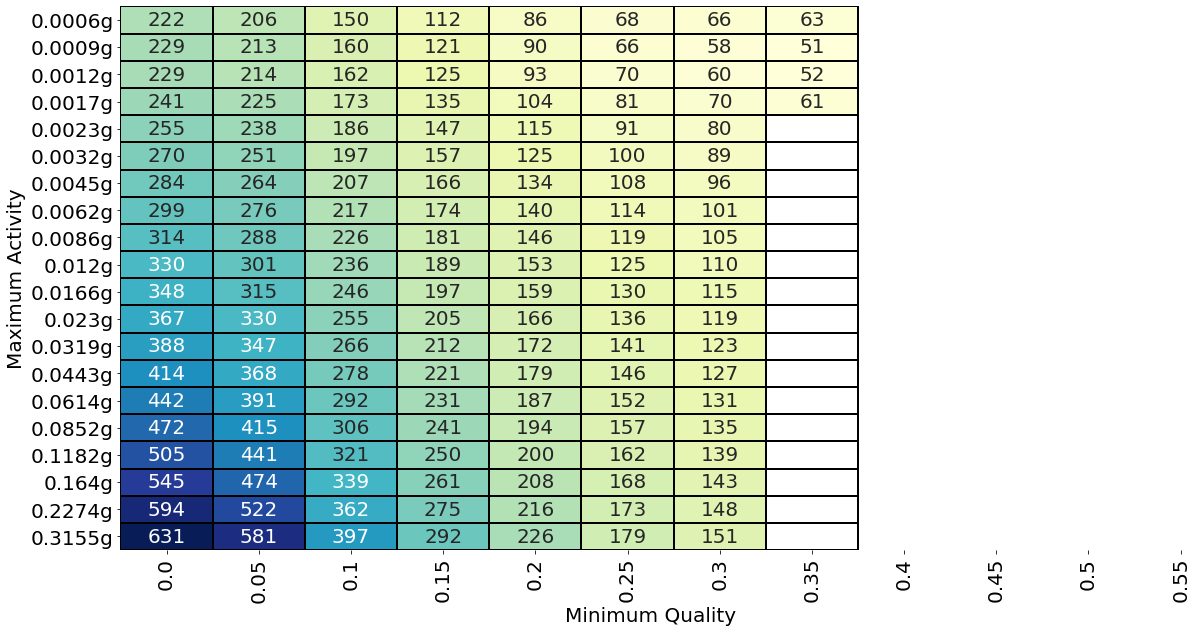

In [2]:
import pickle
data  = pickle.load(open('final_yield_accuracy_error.p','rb'))

import pandas as pd
a = pd.pivot_table(data,columns='Minimum Quality',index='Maximum Activity',values='Minutes per day',aggfunc='mean')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(19,10))
sns.heatmap(a,annot=True,fmt='.0f',xticklabels=1,yticklabels=1,cbar=False,linewidths=1, linecolor='black',cmap="YlGnBu")
plt.xticks(np.array(range(len(np.arange(0,.6,.05))))+.5,[np.round(100*a)/100 for a in np.arange(0,.6,.05)])
plt.yticks(np.array(range(len(np.logspace(-2.9,-.2,20))))+.5,[str(np.round(10000*(a/2))/10000)+'g' for a in np.logspace(-2.9,-.2,20)])
plt.show()

In [ ]:
from copy import deepcopy
results = []
for minimum  in [20,30,40]:
    x = np.arange(.1,.3,.02)
#     x = np.arange(0,.95,.05)
    y = []
    for threshold in x:
        temp = deepcopy(final_final_data)
        temp['rr_col'] = temp['rr_col'].apply(lambda a:a[a[:,2]<threshold])
        temp['len'] = temp['rr_col'].apply(lambda a:a.shape[0])
        tmp = temp[temp.len>=minimum]
#         temp['likelihood_max'] = temp['rr_col'].apply(lambda a: np.percentile(a,100*(1-minimum/len(a))))
#         tmp = temp[temp.likelihood_max>=threshold]
        yield_ = tmp.shape[0]/tmp.user_day_hand.unique().shape[0]
        y.append(yield_)
        print(threshold,y[-1])
    results.append(np.vstack([x,y]).T)
    print(list(zip(x,y)))

In [ ]:
# pickle.dump(results,open('results.p','wb'))
np.arange(.002,.2,.002)

In [ ]:
result_20 = results[0]
result_30 = results[1]
result_40 = results[2]
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(14,10))
plt.plot(result_20[:,0],result_20[:,1],'-',label='p = 33.33%',linewidth=3)
plt.plot(result_30[:,0],result_30[:,1],':',label='p = 50%',linewidth=3)
plt.plot(result_40[:,0],result_40[:,1],'-.',label='p = 66.66%',linewidth=3)
# plt.vlines(.05,0,585)
# plt.vlines(.1,0,408)
# plt.vlines(.15,0,306)
# plt.vlines(.2,0,246)
plt.xlabel('Minimum Signal Quality Threshold')
plt.ylabel('Yield in Field \n Minutes per participant-wrist day ')
plt.xticks(np.arange(0,.95,.05),np.round(np.arange(0,.95,.05)*100)/100,rotation=60)
plt.legend()
plt.grid()
plt.ylim([0,700])
ax = plt.gca()
axy = ax.twinx()
axy.plot(want[:,0],want[:,1],'--',c='r',marker='o',linewidth=2,markersize=10,label='LOSO F1 - Using Quality Weighted Features')
axy.plot(not_want[:,0],not_want[:,1],'--',c='lime',marker='s',linewidth=2,markersize=10,label='LOSO F1 - Using Original Features')
axy.set_ylabel('Lab Stress Classification Results \n LOSO F1 Score',color='black')
axy.tick_params(axis='y', colors='brown')
axy.legend(loc='center right')
plt.show()

In [ ]:
import pickle
import numpy as np
import seaborn
import pandas as pd
# want,not_1ant
want = pickle.load(open('../data/stress_with_quality_without_normalization7.p','rb'))
not_want = pickle.load(open('../data/stress_without_quality_without_normalization7.p','rb'))
index = [0,3,4,5]
want =np.array([np.array(i[0])[index] for i in want])
not_want = np.array([np.array(i[0])[index] for i in not_want])

In [ ]:
result_30 = result_30[result_30[:,0]<=.5,:]

In [ ]:
all_data_want = np.hstack((want, result_30))
all_data_not_want = np.hstack((not_want, result_30))

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(all_data_want[:,-1],all_data_want[:,1],'--',marker='o',linewidth=3,markersize=10,label='Using Quality Weighted Features')
plt.plot(all_data_not_want[:,-1],all_data_not_want[:,1],':',marker='s',linewidth=3,markersize=10,label='Using Original Features')
plt.hlines(.675,0,263.35,color='black')
plt.vlines(263.35,0,.675,linestyle='--',color='b')
plt.vlines(192,0,.675,linestyle='--',color='b')
plt.ylim([.63,.77])
plt.xlim([80,700])
plt.legend()
plt.xlabel('Minutes per participant-wrist day ')
plt.ylabel('Leave one subject F1 Score')

In [ ]:
all_data_not_want

In [ ]:
index = [0,3,4,5]
want =np.array([np.array(i[0])[index] for i in want])

not_want = np.array([np.array(i[0])[index] for i in not_want])
final = []
for i in range(11):
    final.append([want[i][0],want[i][1],'Quality Weighted Features'])
#     final.append([want[i][0],want[i][2],'Precision','Using Quality Weighted Features'])
#     final.append([want[i][0],want[i][3],'Recall','Using Quality Weighted Features'])

for i in range(11):
    final.append([not_want[i][0],not_want[i][1],'Original Features'])
#     final.append([not_want[i][0],not_want[i][2],'Precision','Using Quality Weighted Features'])
#     final.append([not_want[i][0],not_want[i][3],'Recall','Using Quality Weighted Features'])

df = pd.DataFrame(final,columns=['Quality Threshold','F1 Score','Type of Features'])
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({"font.size":20})
import seaborn as sns
plt.figure(figsize=(12,8))
# sns.lineplot(x='Quality Threshold',y='F1 Score',hue='Type of Features',data=df, dashes=True)
plt.plot(want[:,0],want[:,1],'--',marker='o',linewidth=3,markersize=20,label='Using Quality Weighted Features')
plt.plot(not_want[:,0],not_want[:,1],'--',marker='s',linewidth=3,markersize=20,label='Using Normal Features')
plt.ylabel('F1 score')
plt.xlabel('Minimum Signal Quality')
plt.legend()
# plt.xticks(want[:,0],want[:,0])
plt.show()

In [ ]:
want.shape

In [ ]:
final_final_data.shape

In [ ]:
[.1,.2,.1,.3,.4,.5,.1]

In [ ]:
temp.head()